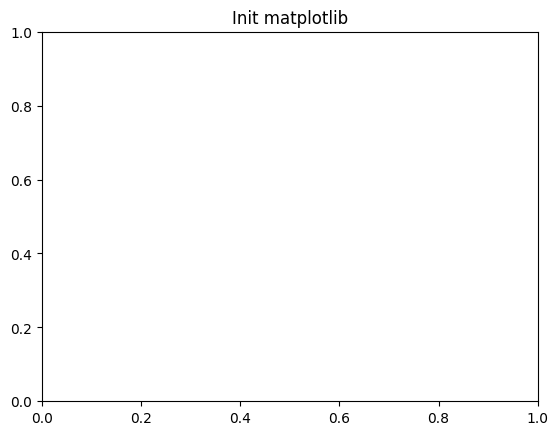

In [1]:
import matplotlib.pyplot as plt

# plt.figure(figsize=(8,8))
# plt.axis("off")
plt.title("Init matplotlib")
plt.show()

In [2]:
#%matplotlib inline
import argparse
import os
import random

import torch
import torch.nn as nn
import torch.nn.parallel
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils

import numpy as np
import matplotlib.animation as animation
from IPython.display import HTML

from torchsummary import summary

# Set random seed for reproducibility
manualSeed = random.randint(1, 10000)
print("Random Seed: ", manualSeed)

random.seed(manualSeed)
torch.manual_seed(manualSeed)

Random Seed:  1486


In [3]:
dataroot = "D:\datasets\celeba" # Root directory for dataset 
workers = 2 # Number of workers for dataloader
batch_size = 128 # Batch size during training
image_size = 64 # All images will be resized to this size

nc = 3 # Number of channels in the training images. For color images this is 3
nz = 128 # Size of z latent vector (i.e. size of generator input)
ngf = 64 # Size of feature maps in generator
ndf = 64 # Size of feature maps in discriminator

num_epochs = 24 # Number of training epochs

lr = 0.0002 # Learning rate for optimizers
beta1 = 0.5 # Beta1 hyperparameter for Adam optimizers

ngpu = 1 # Number of GPUs available. Use 0 for CPU mode.

In [4]:
# Create the dataset
dataset = dset.ImageFolder(root=dataroot,
                           transform=transforms.Compose([
                               transforms.Resize(image_size),
                               transforms.CenterCrop(image_size),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ]))
# Create the dataloader
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=workers)

In [5]:
# Decide which device we want to run on
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")
print(device)

cuda:0


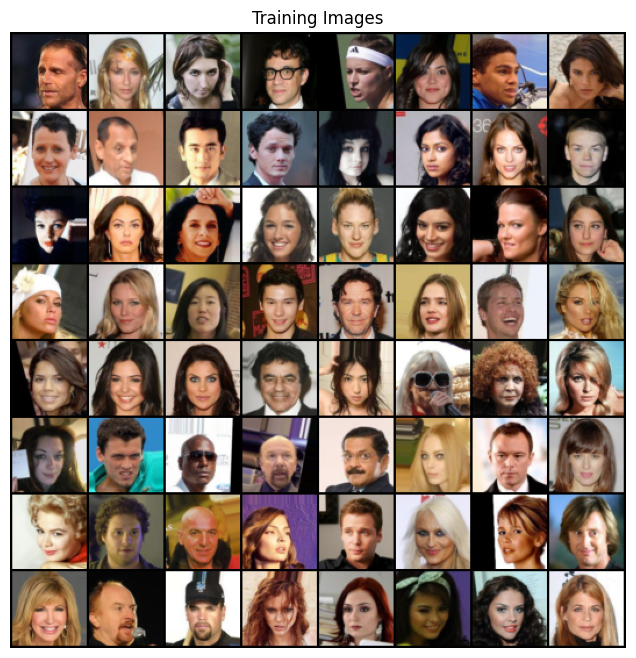

In [6]:
# Plot some training images
real_batch = next(iter(dataloader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))
plt.show()

In [7]:
# custom weights initialization called on ``dc_generator`` and ``dc_discriminator``
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [8]:
# Generator Code
class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d( nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # state size. ``(ngf*8) x 4 x 4``
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. ``(ngf*4) x 8 x 8``
            nn.ConvTranspose2d( ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. ``(ngf*2) x 16 x 16``
            nn.ConvTranspose2d( ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # state size. ``(ngf) x 32 x 32``
            nn.ConvTranspose2d( ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. ``(nc) x 64 x 64``
        )

    def forward(self, input):
        return self.main(input)

In [9]:
# Create the generator
dc_generator = Generator(ngpu).to(device)

# Handle multi-GPU if desired
if (device.type == 'cuda') and (ngpu > 1):
    dc_generator = nn.DataParallel(dc_generator, list(range(ngpu)))

# Weigth initialization
dc_generator.apply(weights_init)

summary(dc_generator, (nz, 1,1))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
   ConvTranspose2d-1            [-1, 512, 4, 4]       1,048,576
       BatchNorm2d-2            [-1, 512, 4, 4]           1,024
              ReLU-3            [-1, 512, 4, 4]               0
   ConvTranspose2d-4            [-1, 256, 8, 8]       2,097,152
       BatchNorm2d-5            [-1, 256, 8, 8]             512
              ReLU-6            [-1, 256, 8, 8]               0
   ConvTranspose2d-7          [-1, 128, 16, 16]         524,288
       BatchNorm2d-8          [-1, 128, 16, 16]             256
              ReLU-9          [-1, 128, 16, 16]               0
  ConvTranspose2d-10           [-1, 64, 32, 32]         131,072
      BatchNorm2d-11           [-1, 64, 32, 32]             128
             ReLU-12           [-1, 64, 32, 32]               0
  ConvTranspose2d-13            [-1, 3, 64, 64]           3,072
             Tanh-14            [-1, 3,

In [10]:
class Discriminator(nn.Module):
    def __init__(self, ngpu):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is ``(nc) x 64 x 64``
            nn.utils.spectral_norm(nn.Conv2d(nc, ndf, 4, 2, 1, bias=False)),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. ``(ndf) x 32 x 32``
            nn.utils.spectral_norm(nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False)),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. ``(ndf*2) x 16 x 16``
            nn.utils.spectral_norm(nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False)),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. ``(ndf*4) x 8 x 8``
            nn.utils.spectral_norm(nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False)),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. ``(ndf*8) x 4 x 4``
            nn.utils.spectral_norm(nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False)),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)

In [11]:
# Create the Discriminator
dc_discriminator = Discriminator(ngpu).to(device)

# Handle multi-GPU if desired
if (device.type == 'cuda') and (ngpu > 1):
    dc_discriminator = nn.DataParallel(dc_discriminator, list(range(ngpu)))

# Weigth initialization
dc_discriminator.apply(weights_init)

summary(dc_discriminator, (3, 64, 64))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           3,072
         LeakyReLU-2           [-1, 64, 32, 32]               0
            Conv2d-3          [-1, 128, 16, 16]         131,072
       BatchNorm2d-4          [-1, 128, 16, 16]             256
         LeakyReLU-5          [-1, 128, 16, 16]               0
            Conv2d-6            [-1, 256, 8, 8]         524,288
       BatchNorm2d-7            [-1, 256, 8, 8]             512
         LeakyReLU-8            [-1, 256, 8, 8]               0
            Conv2d-9            [-1, 512, 4, 4]       2,097,152
      BatchNorm2d-10            [-1, 512, 4, 4]           1,024
        LeakyReLU-11            [-1, 512, 4, 4]               0
           Conv2d-12              [-1, 1, 1, 1]           8,192
          Sigmoid-13              [-1, 1, 1, 1]               0
Total params: 2,765,568
Trainable param

In [12]:
# Initialize the ``BCELoss`` function
criterion = nn.BCELoss()

# Create batch of latent vectors that we will use to visualize the progression of the generator
fixed_noise = torch.randn(64, nz, 1, 1, device=device)

# Establish convention for real and fake labels during training
real_label = 1.
fake_label = 0.

# Setup Adam optimizers for both G and D
optimizerD = optim.Adam(dc_discriminator.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(dc_generator.parameters(), lr=lr, betas=(beta1, 0.999))

In [13]:
# Training Loop

# Lists to keep track of progress
img_list = []
G_losses = []
D_losses = []
iters = 0

print("Starting Training Loop...")
# For each epoch
for epoch in range(num_epochs):
    # For each batch in the dataloader
    for i, data in enumerate(dataloader, 0):

        ############################
        # Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        
        dc_discriminator.zero_grad()
        real_data = data[0].to(device)
        batch_size = real_data.size(0)

        # Real data
        
        label = torch.full((batch_size,), real_label, dtype=torch.float, device=device)
        output = dc_discriminator(real_data).view(-1)

        errD_real = criterion(output, label)
        errD_real.backward()
        eval_real = output.mean().item()

        # Fake data
        
        noise = torch.randn(batch_size, nz, 1, 1, device=device)
        fake = dc_generator(noise)
        
        label.fill_(fake_label)
        output = dc_discriminator(fake.detach()).view(-1)
        
        errD_fake = criterion(output, label)
        errD_fake.backward()
        eval_fake_1 = output.mean().item()
        
        errD = errD_real + errD_fake
        optimizerD.step()

        ############################
        # Update G network: maximize log(D(G(z)))
        ###########################
        
        dc_generator.zero_grad()
        label.fill_(real_label) 
        
        output = dc_discriminator(fake).view(-1)
        errG = criterion(output, label)

        errG.backward()
        eval_fake_2 = output.mean().item()

        optimizerG.step()

        # Output training stats
        if i % 50 == 0:
            print('[%d/%d][%d/%d]  \tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, num_epochs, i, len(dataloader),
                     errD.item(), errG.item(), eval_real, eval_fake_1, eval_fake_2))

        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())

        # Check how the generator is doing by saving G's output on fixed_noise
        if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
            with torch.no_grad():
                fake = dc_generator(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

        iters += 1

Starting Training Loop...
[0/24][0/1583]  	Loss_D: 1.3029	Loss_G: 5.2771	D(x): 0.6011	D(G(z)): 0.5073 / 0.0061
[0/24][50/1583]  	Loss_D: 2.9207	Loss_G: 23.1044	D(x): 0.2938	D(G(z)): 0.0000 / 0.0000
[0/24][100/1583]  	Loss_D: 0.3441	Loss_G: 3.6079	D(x): 0.8281	D(G(z)): 0.0794 / 0.0387
[0/24][150/1583]  	Loss_D: 0.4303	Loss_G: 3.6390	D(x): 0.7700	D(G(z)): 0.1045 / 0.0422
[0/24][200/1583]  	Loss_D: 0.6225	Loss_G: 5.9269	D(x): 0.8453	D(G(z)): 0.3112 / 0.0049
[0/24][250/1583]  	Loss_D: 0.5437	Loss_G: 3.7770	D(x): 0.7503	D(G(z)): 0.0848 / 0.0381
[0/24][300/1583]  	Loss_D: 0.4124	Loss_G: 2.8445	D(x): 0.8142	D(G(z)): 0.1425 / 0.0844
[0/24][350/1583]  	Loss_D: 1.0380	Loss_G: 2.8032	D(x): 0.5096	D(G(z)): 0.0362 / 0.0983
[0/24][400/1583]  	Loss_D: 0.6841	Loss_G: 5.7844	D(x): 0.9436	D(G(z)): 0.4022 / 0.0060
[0/24][450/1583]  	Loss_D: 0.5475	Loss_G: 4.3747	D(x): 0.7932	D(G(z)): 0.2125 / 0.0197
[0/24][500/1583]  	Loss_D: 0.3193	Loss_G: 3.7723	D(x): 0.8690	D(G(z)): 0.1403 / 0.0325
[0/24][550/1583]  	

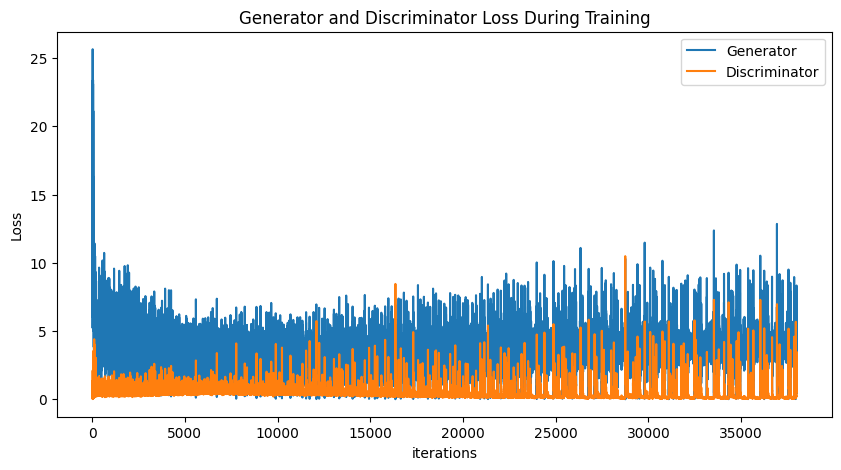

In [14]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="Generator")
plt.plot(D_losses,label="Discriminator")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

Animation size has reached 15941253 bytes, exceeding the limit of 15728640.0. If you're sure you want a larger animation embedded, set the animation.embed_limit rc parameter to a larger value (in MB). This and further frames will be dropped.


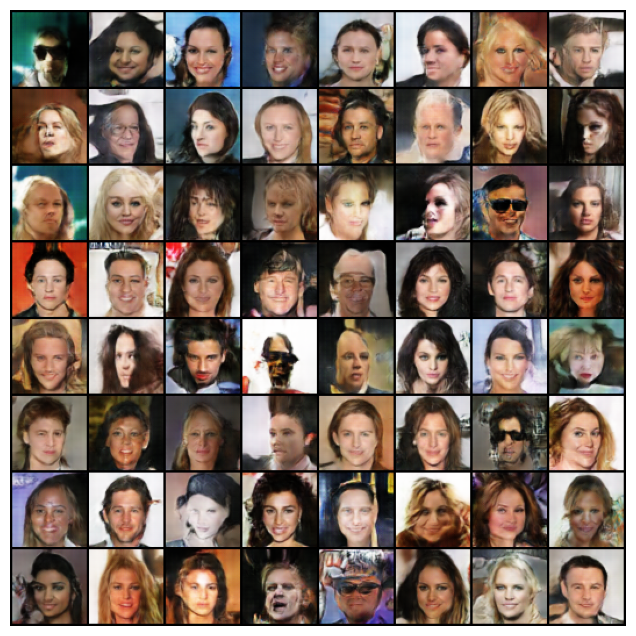

In [15]:
fig = plt.figure(figsize=(8,8))
plt.axis("off")

plt.rcParams['animation.embed_limit'] = 15.0

ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in img_list]
ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)

HTML(ani.to_jshtml())

ani.save('animation.gif', writer='pillow', fps=1)Animation size has reached 15941253 bytes, exceeding the limit of 15728640.0. If you're sure you want a larger animation embedded, set the animation.embed_limit rc parameter to a larger value (in MB). This and further frames will be dropped.

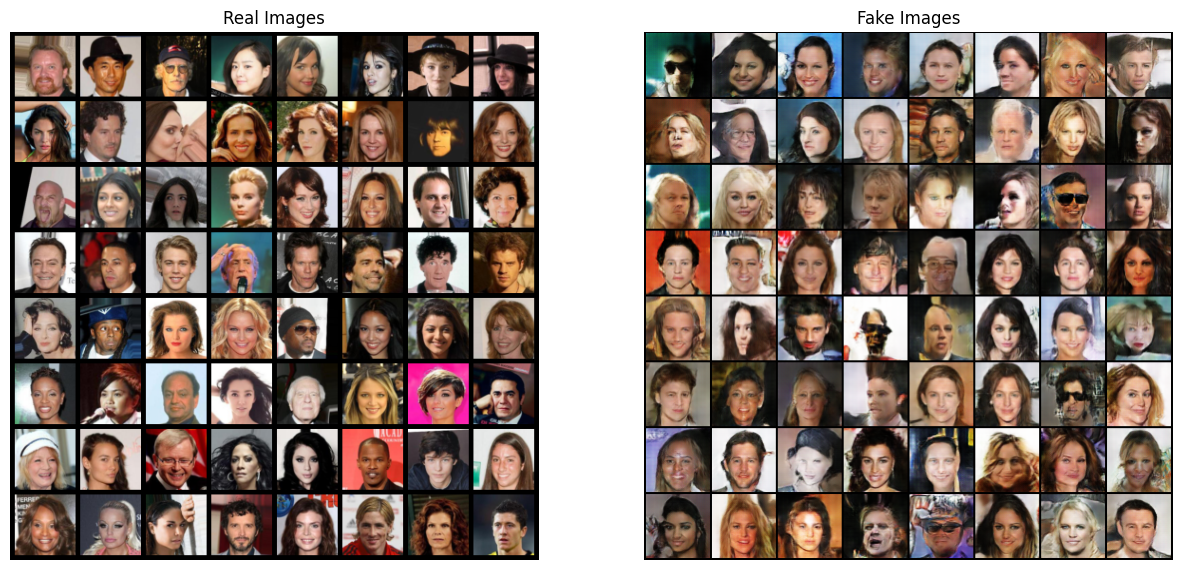

In [16]:
# Grab a batch of real images from the dataloader
real_batch = next(iter(dataloader))

# Plot the real images
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))

# Plot the fake images from the last epoch
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(img_list[-1],(1,2,0)))
plt.show()

In [17]:
torch.save(dc_discriminator, "sn_discriminator.pth")
torch.save(dc_generator, "sn_generator.pth")